In [20]:
# Celda 1: Imports y par√°metros y argparse para variables desde terminal
import numpy as np                      # Celdas: 2,3,4,5,6,7,8 (NP arrays, random choice with rng)
import matplotlib.pyplot as plt         # Celdas: 2,6,7,8 (Visualizaci√≥n, gr√°ficos, animaci√≥n)
import time                             # Celda: 5 (Medici√≥n de tiempos)
from tqdm import tqdm                   # Celda: 5 (Barra de progreso, opcional)
import argparse                         # Celdas: 1 (parseo de argumentos)
import sys                              # Para obtener argv en parse_known_args
from numba import njit, set_num_threads, get_num_threads, prange
import os                               # Para obtener el n√∫mero de hilos disponibles
import h5py  # Para guardar resultados en formato HDF5
import subprocess, threading, re, math # √öltima celda para la generaci√≥n del video

# ‚îÄ‚îÄ‚îÄ Funciones de validaci√≥n de argumentos ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def positive_int(value):
    try:
        iv = int(value)
    except ValueError:
        raise argparse.ArgumentTypeError(f"Valor inv√°lido para argumento entero: '{value}'")
    if iv <= 0:
        raise argparse.ArgumentTypeError(f"El valor debe ser un entero positivo: {iv}")
    return iv

# ‚îÄ‚îÄ‚îÄ An√°lisis de argumentos (compatibilidad Jupyter) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
parser = argparse.ArgumentParser(
    description='Simulaci√≥n Monte Carlo de Ising 2D con din√°mica de Kawasaki')
parser.add_argument('--L',       type=positive_int, default=500,    help='Tama√±o de la red LxL (entero positivo)')
parser.add_argument('--J',       type=float,       default=1.0,   help='Constante de acoplamiento')
parser.add_argument('--T',       type=float,       default=2.269, help='Temperatura (k_B=1)')
parser.add_argument('--n_sweeps',type=positive_int, default=50000,  help='N√∫mero de barridos Monte Carlo (entero positivo)')
parser.add_argument('--seed',    type=int,         default=None,  help='Semilla para RNG (None: entrop√≠a)')
# parse_known_args ignora flags desconocidos (como los de Jupyter)
args, _ = parser.parse_known_args(sys.argv[1:])

# ‚îÄ‚îÄ‚îÄ Par√°metros del modelo ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
L        = args.L
J        = args.J
T        = 10
n_sweeps = args.n_sweeps

# ‚îÄ‚îÄ‚îÄ Configuraci√≥n de semilla para reproducibilidad ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
seed = args.seed                       # None = usar entrop√≠a del sistema
rng  = np.random.default_rng(seed)     # PCG64 RNG: seguro y adecuado para simulaciones

#Establecer el n√∫mero de hilos a usar
n_threads_available = os.cpu_count()
set_num_threads(int(n_threads_available))
n_threads = get_num_threads()

print(f"Usando {n_threads} hilos de {n_threads_available} disponibles (100%).")


Usando 16 hilos de 16 disponibles (100%).


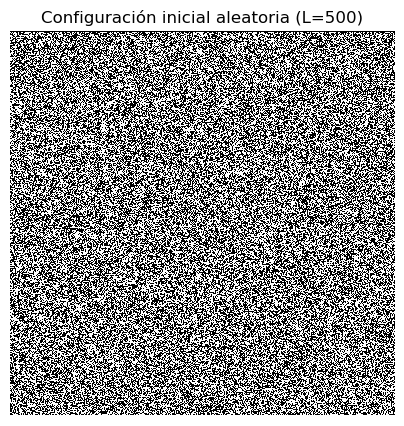

In [21]:
# ‚îÄ‚îÄ‚îÄ Celda 2: Inicializaci√≥n de la red y visualizaci√≥n ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# Generar configuraci√≥n inicial aleatoria de espines ¬±1
def init_config(L, rng):
    """
    Crea una matriz LxL de espines aleatorios ¬±1 usando el RNG proporcionado.
    """
    return rng.choice([1, -1], size=(L, L))

# Forzar que la fila de arriba sea negativa y la de abajo positiva
def force_boundary_conditions(config):
    """
    Fuerza las condiciones de frontera: fila superior -1, fila inferior +1.
    """
    config[0, :] = -1  # Fila superior
    config[L-1, :] = 1  # Fila inferior
    return config

# Crear configuraci√≥n y mostrarla
config = init_config(L, rng)
config = force_boundary_conditions(config)
plt.figure(figsize=(5,5))
plt.imshow(config, cmap='gray', interpolation='nearest')
plt.title(f'Configuraci√≥n inicial aleatoria (L={L})')
plt.axis('off')
plt.show()


In [22]:
# ‚îÄ‚îÄ‚îÄ Celda 3: Definici√≥n de observables termodin√°micos ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

def energy(config, J=J):
    """
    Calcula la energ√≠a total del modelo de Ising 2D con contorno peri√≥dico.
    """
    # Enlaces derecha e inferior para contar cada par una sola vez
    right = np.roll(config, -1, axis=1)
    down  = np.roll(config, -1, axis=0)
    return -J * np.sum(config * (right + down))


def magnetization(config):
    """
    Calcula la magnetizaci√≥n total del sistema.
    """
    return np.sum(config)

# Ejemplo de uso en Celda 3
E0 = energy(config)
M0 = magnetization(config)
print(f"Energ√≠a inicial: {E0:.2f}, Magnetizaci√≥n inicial: {M0}")


Energ√≠a inicial: -64.00, Magnetizaci√≥n inicial: -842


In [23]:
# ‚îÄ‚îÄ‚îÄ Celda 4: Funciones c√°lculo varias ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

def calculate_acceptance(frames: np.ndarray) -> np.ndarray:
    
    nframes, H, W = frames.shape
    # `True` donde el esp√≠n cambi√≥ respecto al sweep anterior
    changes = frames[1:] != frames[:-1]               # shape (nframes-1, H, W)
    diff_counts = changes.reshape(nframes-1, -1).sum(axis=1)
    # Cada swap v√°lido intercambia dos posiciones
    accepted_swaps = diff_counts / 2
    # N¬∫ de intentos de swap por sweep ‚âà H*W
    attempts = H * W
    acceptance = accepted_swaps / attempts
    return acceptance


@njit
def delta_E_kawasaki(config, i, j, k, l, J=J):
    """
    Calcula el cambio de energ√≠a ŒîE para un intercambio de espines en la din√°mica de Kawasaki.
    """
    #Calculamos la energ√≠a de la configuraci√≥n inicial
    E_1 = -J*(config[i,j]*(config[i,(j-1)%L] + config[(i-1)%L,j] + config[(i+1)%L,j] + config[i,(j+1)%L])+config[k,l]*(config[k,(l-1)%L] + config[(k-1)%L,l] + config[(k+1)%L,l] + config[k,(l+1)%L]))
   
    #Calculamos la energ√≠a de la configuraci√≥n final
    E_2 = -J*(config[k,l]*(config[i,(j-1)%L] + config[(i-1)%L,j] + config[(i+1)%L,j] + config[i,(j+1)%L])+config[i,j]*(config[k,(l-1)%L] + config[(k-1)%L,l] + config[(k+1)%L,l] + config[k,(l+1)%L]))
    #Calculamos el cambio de energ√≠a
    delta_E = E_2 - E_1
    return delta_E


#Paso de la simulaci√≥n
@njit   
def sweep_kawasaki(config, L, J, T):
    for k in prange(L*L):
        #Seleccionamos un esp√≠n aleatorio (i, j) de la red excluyendo las filas superior e inferior
        i, j = np.random.randint(1, L-1), np.random.randint(0, L)
        # Definimos los offsets para los vecinos (arriba, abajo, izquierda, derecha)
        offsets = np.array([(1, 0), (0, 1), (0, -1),  (-1, 0)], dtype=np.int64)
        # Ahora seleccionamos un offset aleatorio que decidir√° si escogemos un vecino arriba, abajo, izquierda o derecha
        #Hay que mantener la condici√≥n de los espines superior e inferior.
        # Entonces lo que hacemos es limitar los offsets a 3 si estamos en la fila superior o inferior, y a 4 si estamos en el resto de la red.
        # Y luego forzamos que si est√° en la fila
        if i == 1:
            di, dj = offsets[np.random.randint(0, 3)]
        elif i == L-2:
            di, dj = offsets[np.random.randint(1, 4)]
        else:
            di, dj = offsets[np.random.randint(0, 4)]
        # Ahora podemos calcular la posici√≥n exacta del esp√≠n vecino
        ni, nj = (i + di) % L, (j + dj) % L
        # Ahora que tenemos la posici√≥n del esp√≠n vecino, podemos calcular el ŒîE
        delta_E = delta_E_kawasaki(config, i, j, ni, nj, J)
        # Ahora que tenemos el ŒîE, podemos decidir si aceptamos o no el movimiento
        # La condici√≥n b√°sicamente es que para ŒîE <= 0, aceptamos el movimiento, ya que de ser as√≠ la probabilidad de aceptaci√≥n es 1.
        # Si ŒîE > 0, aceptamos el movimiento con probabilidad p = exp(-ŒîE/T), y lo m√°s eficiente es generar un n√∫mero aleatorio entre 0 y 1 y comparar con p,
        # ya que si el n√∫mero aleatorio es menor o igual que p, aceptamos el movimiento.
        if delta_E <= 0 or np.random.random() < np.exp(-delta_E / T):
            # Intercambiar espines
            config[i, j], config[ni, nj] = config[ni, nj], config[i, j]
    


MC Sweeps:   0%|          | 0/50000 [00:00<?, ?it/s]

MC Sweeps: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50000/50000 [50:33<00:00, 16.48it/s]  


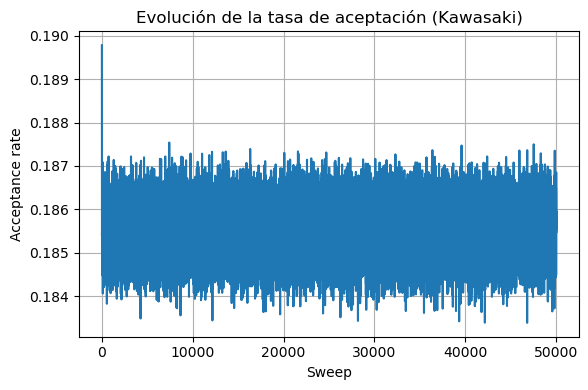

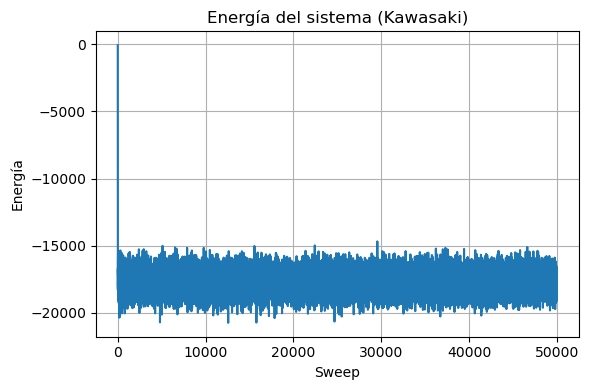

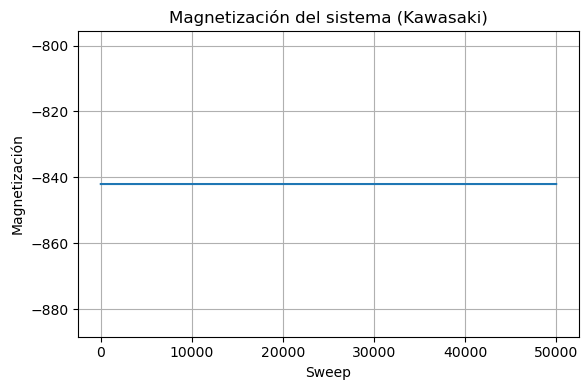

Simulaci√≥n completada en 3033.8363 s


In [ ]:
# ‚îÄ‚îÄ‚îÄ Celda 5: Bucle Monte Carlo y recolecci√≥n de datos con HDF5 ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# Inicializar arrays para almacenar energ√≠a y magnetizaci√≥n
energies = np.zeros(n_sweeps + 1)
magnetizations = np.zeros(n_sweeps + 1)

# Par√°metros de guardado
thin = 1        # guardar cada ‚Äòthin‚Äô sweeps (ajusta a 1 si quieres todos)
n_saved = (n_sweeps // thin) + 1

# Prepara el fichero HDF5 y mantenlo abierto durante toda la simulaci√≥n
destino = 'configs.h5'
with h5py.File(destino, 'w') as f:
    # Dataset para las configuraciones: snapshots √ó L √ó L, dtype int8
    ds = f.create_dataset(
        'configs',
        shape=(n_saved, L, L),
        dtype='i1',
        compression='gzip',
        compression_opts=4,
        chunks=(1, L, L),
    )
    # Metadatos
    f.attrs['J'] = J
    f.attrs['T'] = T
    f.attrs['L'] = L
    f.attrs['n_sweeps'] = n_sweeps
    f.attrs['thin'] = thin

    # Medir estado inicial
    energies[0] = energy(config, J)
    magnetizations[0] = magnetization(config)
    # Guardar configuraci√≥n inicial ds[0]
    ds[0, :, :] = config

    # Barrido Monte Carlo
    start_time = time.time()
    idx = 1  # √≠ndice para guardar snapshots
    for sweep in tqdm(range(1, n_sweeps + 1), desc='MC Sweeps'):  # Esto es una simple barra de progreso, nada m√°s
        # Ahora podemos barrer la red para elegir el par de espines a intercambiar.
        sweep_kawasaki(config, L, J, T)
        # Registrar observables
        energies[sweep] = energy(config, J)
        magnetizations[sweep] = magnetization(config)
        

        # Almacenar las configuraciones ‚Äúthinned‚Äù si toca
        if sweep % thin == 0:
            ds[idx, :, :] = config
            idx += 1

    end_time = time.time()

# Plotear los datos importantes
# ‚îÄ‚îÄ‚îÄ Acceptance rate ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

# 1) Cargar todos los frames desde el HDF5
with h5py.File('configs.h5', 'r') as f:
    frames = f['configs'][:]    # np.ndarray (nframes, H, W)

# 2) Calcular la aceptaci√≥n
acceptance = calculate_acceptance(frames)

# 3) Representar la evoluci√≥n de la tasa de aceptaci√≥n
sweeps = np.arange(1, len(acceptance) + 1)
plt.figure(figsize=(6, 4))
plt.plot(sweeps, acceptance, linestyle='-')
plt.xlabel('Sweep')
plt.ylabel('Acceptance rate')
plt.title('Evoluci√≥n de la tasa de aceptaci√≥n (Kawasaki)')
plt.grid(True)
plt.tight_layout()
plt.show()

# ‚îÄ‚îÄ‚îÄ Energ√≠a ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

n_sweeps_array = np.arange(n_sweeps + 1)

plt.figure(figsize=(6, 4))
plt.plot(n_sweeps_array, energies, linestyle='-')
plt.xlabel('Sweep')
plt.ylabel('Energ√≠a')
plt.title('Energ√≠a del sistema (Kawasaki)')
plt.grid(True)
plt.tight_layout()
plt.show()

# ‚îÄ‚îÄ‚îÄ Magnetizaci√≥n ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

plt.figure(figsize=(6, 4))
plt.plot(n_sweeps_array, magnetizations, linestyle='-')
plt.xlabel('Sweep')
plt.ylabel('Magnetizaci√≥n')
plt.title('Magnetizaci√≥n del sistema (Kawasaki)')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Simulaci√≥n completada en {end_time - start_time:.4f} s")


In [8]:
# %% Celda: pipeline GPU-BOUND con NVENC a partir de HDF5

# ‚îÄ‚îÄ Par√°metros de usuario ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
HDF5_FILE = "configs.h5"
DATASET   = "configs"
FILE_OUT  = "simulacion"
GPU_ID    = 0           # 0 = tu NVIDIA 4050
INTERVAL  = 50          # ms entre frames ‚Üí fps = 1000/INTERVAL
TARGET_W  = 1440        # ancho deseado; None para mantener original
TARGET_H  = None        # alto deseado; None para mantener original
MIN_SIDE  = 160         # m√≠nimo seguro para NVENC (‚â• 145 y par)
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

# 1) Cargar datos --------------------------------------------------------------
with h5py.File(HDF5_FILE, 'r') as f:
    frames = f[DATASET][:]
nframes, h0, w0 = frames.shape
fps = 1000.0 / INTERVAL
print(f"‚Üí {nframes} frames ({w0}√ó{h0}px) @ {fps:.1f} fps")

# 2) Calcular resoluci√≥n de salida --------------------------------------------
w_out, h_out = w0, h0
if TARGET_W and not TARGET_H:
    scale = TARGET_W / w0
    w_out = TARGET_W
    h_out = int(round(h0 * scale))
elif TARGET_H and not TARGET_W:
    scale = TARGET_H / h0
    h_out = TARGET_H
    w_out = int(round(w0 * scale))
elif TARGET_W and TARGET_H:
    w_out, h_out = TARGET_W, TARGET_H

# Asegurar m√≠nimo NVENC
if min(w_out, h_out) < MIN_SIDE:
    factor = math.ceil(MIN_SIDE / min(w_out, h_out))
    w_out *= factor
    h_out *= factor
    print(f"‚ö†Ô∏è Redimensionado extra para m√≠nimo NVENC ({MIN_SIDE}px)")

# Redondear a par
w_out = (w_out // 2) * 2
h_out = (h_out // 2) * 2
if (w_out, h_out) != (w0, h0):
    print(f"üîß Escalando: {w0}√ó{h0} ‚Üí {w_out}√ó{h_out}")
vf_filter = ["-vf", f"scale={w_out}:{h_out}:flags=neighbor"] if (w_out, h_out) != (w0, h0) else []

# 3) Detectar NVENC ------------------------------------------------------------
encoders = subprocess.run(
    ["ffmpeg", "-hide_banner", "-encoders"],
    capture_output=True, text=True
).stdout
if "h264_nvenc" in encoders:
    print("‚úÖ h264_nvenc detectado ‚Üí GPU")
    video_opts = [
        "-c:v", "h264_nvenc", "-gpu", str(GPU_ID),
        "-preset", "p1", "-profile:v", "high444p", "-pix_fmt", "yuv444p"
    ]
else:
    print("‚ö†Ô∏è NVENC no disponible ‚Üí libx264 (CPU)")
    video_opts = ["-c:v", "libx264", "-preset", "veryslow", "-crf", "0", "-pix_fmt", "yuv420p"]

# 4) Comando FFmpeg ------------------------------------------------------------
cmd = (
    ["ffmpeg", "-y",
     "-f", "rawvideo", "-pix_fmt", "rgb24",
     "-s", f"{w0}x{h0}", "-r", str(fps), "-i", "-",
     "-progress", "pipe:1", "-loglevel", "error"]
    + vf_filter + video_opts + [f"{FILE_OUT}.mp4"]
)
print("FFmpeg:", " ".join(cmd))

# 5) Lanzar FFmpeg -------------------------------------------------------------
proc = subprocess.Popen(
    cmd,
    stdin = subprocess.PIPE,
    stdout = subprocess.PIPE,
    stderr = subprocess.PIPE,
    bufsize = 0
)

# 6) Barra de codificaci√≥n -----------------------------------------------------
pbar_enc = tqdm(total=nframes, desc="üõ†Ô∏è Codificando", unit="frame")
def _watch():
    re_time = re.compile(rb"out_time_ms=(\d+)")
    re_fr   = re.compile(rb"frame=(\d+)")
    while True:
        line = proc.stdout.readline()
        if not line:
            break
        m = re_fr.search(line) or re_time.search(line)
        if m:
            val = int(m.group(1))
            done = val if b"frame" in line else min(nframes, int(round(val * fps / 1000)))
            pbar_enc.n = done
            pbar_enc.refresh()

threading.Thread(target=_watch, daemon=True).start()

# 7) Enviar frames -------------------------------------------------------------
with tqdm(total=nframes, desc="üì§ Enviando frames", unit="frame") as pbar_in:
    for frame in frames:
        # Convertir de Ising (-1,+1) a [0,255] y a RGB
        rgb = np.repeat(((frame + 1) * 127.5).astype(np.uint8)[..., None], 3, axis=2)
        proc.stdin.write(rgb.tobytes())
        pbar_in.update(1)

proc.stdin.close()
proc.wait()
pbar_enc.n = nframes
pbar_enc.refresh()
pbar_enc.close()

print(f"üéâ V√≠deo generado: {FILE_OUT}.mp4 ({w_out}√ó{h_out})")


‚Üí 501 frames (100√ó100px) @ 20.0 fps
üîß Escalando: 100√ó100 ‚Üí 1440√ó1440
‚úÖ h264_nvenc detectado ‚Üí GPU
FFmpeg: ffmpeg -y -f rawvideo -pix_fmt rgb24 -s 100x100 -r 20.0 -i - -progress pipe:1 -loglevel error -vf scale=1440:1440:flags=neighbor -c:v h264_nvenc -gpu 0 -preset p1 -profile:v high444p -pix_fmt yuv444p simulacion.mp4


üõ†Ô∏è Codificando: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 501/501 [00:01<00:00, 447.48frame/s]

üéâ V√≠deo generado: simulacion.mp4 (1440√ó1440)
